# Handwritten Postal Codes

__Convolutional Neural Networks__

_By Marnick van der Arend & Jeroen Smienk_

![Sample Digits](digits-sample.png)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

%matplotlib inline

__MODEL_PATH = 'conv-models'
__DATA_PATH = 'dataset-images'
__TENSOR_LOG_DIR = 'conv-logs'

__LABELS = 10
__IM_SIZE = 32
__N_DIGITS = 4

C:\Users\Jeroen\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Dataset

480 Images consisting of 4 digit postal codes with the label as the file name e.g. `3365.png`.

In [2]:
def binarize(image):
    """
    Returns a binarized image where lighter values are set to 255 and the lower values set to 0.
    """
    blur = cv2.GaussianBlur(image, (5, 5), 0)
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresh

def crop(image):
    """
    Crop an 128x32 image to 4 32x32 images
    """
    digits = []
    x,y,w,h = 0,0,__IM_SIZE,__IM_SIZE
    for i in range(__N_DIGITS):
        x = i*w
        digits.append(image[y:y+h, x:x+w])
    return digits

def get_images_in_path(path, extension):
    """
    Create a list of all images and their file names (labels) in a certain path
    """
    images = []
    labels = []
    for name in os.listdir(path):
        if name.endswith(extension):
            img = cv2.imread(os.path.join(path, name), cv2.IMREAD_GRAYSCALE)
            label = name[:-len(extension)] # remove extension
            digits = crop(binarize(img))
            for i in range(__N_DIGITS):
                images.append(digits[i])
                labels.append(int(label[i]))
    return np.array(images, dtype=np.int32), np.array(labels, dtype=np.int32)

### Creating the dataset

We split the 480 images in 1920 individual black-and-white digits and save them with their correct label as a tuple in a list. We also binarize the images so there is less noise in the images.

In [3]:
images, labels = get_images_in_path(__DATA_PATH, '.png')

Let's see what kind of digits are in the set by plotting them with their labels:

Size of dataset: 1920 images


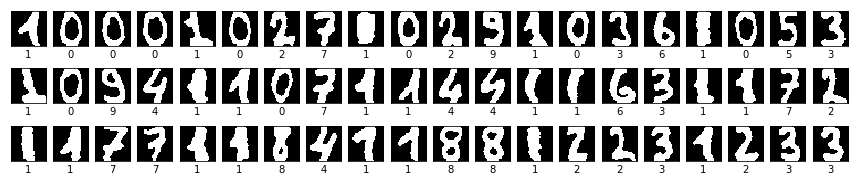

In [4]:
print("Size of dataset: {len} images".format(len=len(images)))

PLOT_SIZE = 60
ROW_WIDTH = 20
plt.figure(figsize=(15, PLOT_SIZE / ROW_WIDTH))
for i in range(PLOT_SIZE):
    plt.subplot(PLOT_SIZE / ROW_WIDTH, ROW_WIDTH, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.xlabel(labels[i])
    plt.imshow(images[i], cmap=plt.cm.binary)

We are also curious how well the digits are distributed:

In [20]:
df = pd.DataFrame(labels, columns=['label'])
df.label.value_counts() / len(df.index)

9    0.106250
7    0.103646
3    0.103646
1    0.103125
6    0.101562
2    0.101562
5    0.097396
4    0.096875
8    0.093750
0    0.092188
Name: label, dtype: float64

Unlike the Yahtzee dataset labels, the distribution of the digits is almost perfect. There are about 10% of every digit in the dataset. Which is pretty equally distributed. This is very good for our deep learning model, because it will prevent bias for a certain label.

#### One-Hot Eencoding

To compare the labels with the predictions of the neural network we need to 'one-hot' encode the labels:

The index of the `1` is the correct label of the data.

In [5]:
def one_hot_encode(labels):
    onehot = np.zeros((len(labels), __LABELS))
    onehot[range(len(labels)), labels] = 1
    return onehot

onehot = one_hot_encode(labels)
print('One hot encoded labels:')
print(onehot[:5])

One hot encoded labels:
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


We combine the data and the labels to be able to shuffle them without forgetting which labels belong to which images.

In [6]:
def get_shuffled_xy(images, onehot):
    data = np.array([np.array([images[i], onehot[i]]) for i in range(len(images))])
    shuffled_data = np.random.permutation(data)
    x = np.array([t[0] for t in shuffled_data])
    x = np.reshape(x, (len(x), 32, 32, 1))
    y = np.array([t[1] for t in shuffled_data])
    return x, y

X, Y = get_shuffled_xy(images, onehot)

print('Images shape: {}'.format(X.shape))
print('Labels shape: {}'.format(Y.shape))

Images shape: (1920, 32, 32, 1)
Labels shape: (1920, 10)


We split the data into train, test, and validation sets.

We use the train set to train; the test set to cross-validate during training; and the validation set to validate the model after the model is done training.

In [7]:
def get_validation_split(x, y, frac):
    split = int(len(x) * frac)
    return x[:split], y[:split], x[split:], y[split:]

X_train, Y_train, X_valid, Y_valid = get_validation_split(X, Y, .85)

def get_test_split(x_train, y_train, frac):
    split = int(len(x_train) * frac)
    return x_train[:split], y_train[:split], x_train[split:], y_train[split:]

X_train, Y_train, X_test, Y_test = get_test_split(X_train, Y_train, .85)

print('Split X (train, test, validation):', X_train.shape, X_test.shape, X_valid.shape)
print('Split Y (train, test, validation):', Y_train.shape, Y_test.shape, Y_valid.shape)

Split X (train, test, validation): (1387, 32, 32, 1) (245, 32, 32, 1) (288, 32, 32, 1)
Split Y (train, test, validation): (1387, 10) (245, 10) (288, 10)


We define a function that returns a random batch of a certain size. This batch is used in training to train faster.

In [8]:
def get_batch(x, y, size):
    batch = np.array([(x[i], y[i]) for i in range(len(x))])
    random_batch = np.random.permutation(batch)[:size]
    return np.array([x[0] for x in random_batch]), np.array([x[1] for x in random_batch])

We also define a function that does all the above so we can load an arbitrary dataset:

In [9]:
def get_folder_xy(path, extension):
    images, labels = get_images_in_path(path, extension)
    return get_shuffled_xy(images, one_hot_encode(labels))

## Models

We designed several models which were run with an iteration count of 1500 and a batch size of 20

rank | name | layers | optimizer | score
--- | --- | --- | --- | ---
? | model_1 | Conv2D(f=64, k=3, s=1, act=relu) | Adam | 0.9444444
? | model_2 | Conv2D(f=64, k=5, act=relu), MaxPool2D(size=2, s=2) | Adam | 0.9652778
? | model_3 | Conv2D(f=32, k=3, s=1, act=relu), Conv2D(f=64, k=3, s=1, act=relu), MaxPool2D(size=2, s=2), Dropout(0.25), Dense(128, act=relu), Dropout(0.5) | Adam | 0.9722222
? | model_4 | Conv2D(f=32, k=3, s=1, act=relu), Conv2D(f=32, k=3, s=1, act=relu), MaxPool2D(size=2, s=2), Conv2D(f=64, k=3, s=1, act=relu), Conv2D(f=64, k=3, s=1, act=relu), Dense(512, act=relu), Dropout(0.2) | Adam | 0.9930556

- Model 1: BLUE
- Model 2: RED
- Model 3: LIGHT BLUE
- Model 4: PINK
- Model 5: GREEN
- Model 6: GRAY
- Model 7: ORANGE
- Model 8: ORANGE

### Batch Accuracy


### Batch Loss


In [10]:
def model_1(x, output_shape):
    """
    One Conv2d layer with a kernel size of 3 and 
    """
    conv1 = tf.layers.conv2d(x, filters=32, kernel_size=3, strides=1, padding="same", 
                           activation=tf.nn.relu)
    
    flatten = tf.contrib.layers.flatten(conv1)
    return tf.layers.dense(flatten, units=output_shape, activation=None)

In [11]:
def model_2(x, output_shape):
    """
    """
    conv1 = tf.layers.conv2d(x, filters=32, kernel_size=5, 
                             padding="same", activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(conv1, pool_size=2, strides=2)
    
    flatten = tf.contrib.layers.flatten(pool1)
    return tf.layers.dense(flatten, units=output_shape, activation=None)

In [12]:
def model_3(x, output_shape):
    """
    """
    #32 convolution filters used each of size 3x3
    conv1 = tf.layers.conv2d(x, filters=32, kernel_size = 3,
                         strides = 1, padding="same",
                         activation = tf.nn.relu)
    
    #64 convolution filters used each of size 3x3
    conv2 = tf.layers.conv2d(conv1, filters=64, kernel_size = 3,
                         strides = 1, padding="same",
                         activation = tf.nn.relu)
    
    #choose the best features via pooling
    pool1 = tf.layers.max_pooling2d(conv2, pool_size=2, strides=2)
    
    #randomly turn neurons on and off to improve convergence
    dropout1 = tf.layers.dropout(pool1, rate=.25)
    
    #flatten since too many dimensions, we only want a classification output
    flatten = tf.contrib.layers.flatten(dropout1)

    #fully connected to get all relevant data
    dense = tf.layers.dense(flatten, units=128, activation=tf.nn.relu)
    
    #one more dropout for convergence' sake :) 
    dropout2 = tf.layers.dropout(dense, rate=.5)

    return tf.layers.dense(dropout2, units=output_shape, activation=None)

In [13]:
def model_4(x, output_shape):
    """
    IMPLEMENT BATCH NORMALIZATION AFTER CONV LAYERS
    """
    conv1 = tf.layers.conv2d(x, filters=32, kernel_size = 3,
                         strides = 1, padding="same",
                         activation = tf.nn.relu)
    
    conv2 = tf.layers.conv2d(conv1, filters=32, kernel_size = 3,
                         strides = 1, padding="same",
                         activation = tf.nn.relu)
        
    pool1 = tf.layers.max_pooling2d(conv2, pool_size=2, strides=2)

    conv3 = tf.layers.conv2d(pool1, filters=64, kernel_size = 3,
                         strides = 1, padding="same",
                         activation = tf.nn.relu)

    conv4 = tf.layers.conv2d(conv3, filters=64, kernel_size = 3,
                         strides = 1, padding="same",
                         activation = tf.nn.relu)

    pool2 = tf.layers.max_pooling2d(conv4, pool_size=2, strides=2)

    flatten = tf.contrib.layers.flatten(pool2)

    # Fully connected layer
    dense = tf.layers.dense(flatten, units=512, activation=tf.nn.relu)

    dropout = tf.layers.dropout(dense, rate=.2)
    
    return tf.layers.dense(dropout, units=output_shape, activation=None)

In [14]:
def model_5(x, output_shape):
    """
    """
    conv1 = tf.layers.conv2d(x, filters=32, kernel_size = 5,
                         strides = 1, padding="same",
                         activation = tf.nn.relu)
    conv2 = tf.layers.conv2d(conv1, filters=32, kernel_size = 5,
                         strides = 1, padding="same",
                         activation = tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(conv2, pool_size=2, strides=2)
    dropout1 = tf.layers.dropout(pool1, rate=.25)
    
    conv3 = tf.layers.conv2d(x, filters=64, kernel_size = 3,
                         strides = 1, padding="same",
                         activation = tf.nn.relu)
    conv4 = tf.layers.conv2d(conv3, filters=64, kernel_size = 3,
                         strides = 1, padding="same",
                         activation = tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(conv4, pool_size=2, strides=2)
    dropout2 = tf.layers.dropout(pool2, rate=.25)
    
    flatten = tf.contrib.layers.flatten(dropout2)
    dense = tf.layers.dense(flatten, units=256, activation=tf.nn.relu)
    dropout = tf.layers.dropout(dense, rate=.5)

    return tf.layers.dense(dropout, units=output_shape, activation=None)

In [15]:
def model_6(x, output_shape):
    
    conv1 = tf.layers.conv2d(x, filters=32, kernel_size = 3,
                         strides = 1, padding = "valid",
                         kernel_initializer = tf.contrib.layers.xavier_initializer(uniform=False),
                         activation = tf.nn.relu)
    conv2 = tf.layers.conv2d(conv1, filters=32, kernel_size = 3,
                         strides = 1, padding = "valid",
                         kernel_initializer = tf.contrib.layers.xavier_initializer(uniform=False),
                         activation = tf.nn.relu)
    
    pool1 = tf.layers.max_pooling2d(conv2, pool_size=2, strides=1)
    dropout1 = tf.layers.dropout(pool1, rate=.2)
    
    conv3 = tf.layers.conv2d(dropout1, filters=64, kernel_size = 3,
                         strides = 1, padding = "same",
                         kernel_initializer = tf.contrib.layers.xavier_initializer(uniform=False),
                         activation = tf.nn.relu)
    conv4 = tf.layers.conv2d(conv3, filters=64, kernel_size = 3,
                         strides = 1, padding = "same",
                         kernel_initializer = tf.contrib.layers.xavier_initializer(uniform=False),
                         activation = tf.nn.relu)
    
    pool2 = tf.layers.max_pooling2d(conv4, pool_size=2, strides=1)
    dropout2 = tf.layers.dropout(pool2, rate=.25)
    
    conv4 = tf.layers.conv2d(dropout2, filters=128, kernel_size = 3,
                         strides = 1, padding = "same",
                         kernel_initializer = tf.contrib.layers.xavier_initializer(uniform=False),
                         activation = tf.nn.relu)
    
    dropout3 = tf.layers.dropout(conv4, rate=.25)
    flatten = tf.contrib.layers.flatten(dropout3)
    dense = tf.layers.dense(flatten, units=128, activation=tf.nn.relu)
    batch_norm = tf.layers.batch_normalization(dense, training=is_training)
    dropout = tf.layers.dropout(batch_norm, rate=.25)
    
    return tf.layers.dense(dropout, units=output_shape, activation=None)

We start with the placeholder for our 32x32 pixel input and 10-class output and choose a model:

In [16]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=[None, X_train.shape[1], X_train.shape[2], 1], name='x')
y = tf.placeholder(tf.float32, shape=[None, Y_train.shape[1]], name='y')
is_training = tf.placeholder(tf.bool, name='is_training')

model_fn = model_6
y_pred = model_fn(x, Y_train.shape[1])

We choose an optimizer and define a loss functon and the accuracy metric:

In [17]:
# Loss function
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=y_pred)
loss_fn = tf.reduce_mean(cross_entropy)

# Optimizer minimizes the loss
optimizer = tf.train.AdamOptimizer(learning_rate=.0001)
# optimizer = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(loss_fn)

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_op = optimizer.minimize(loss_fn)

# Accuracy metric
#   checks if the indices of the highest values in the real 
#   and predicted arrays are equal
prediction = tf.equal(tf.argmax(y, axis=1), tf.argmax(y_pred, axis=1))
accuracy = tf.reduce_mean(tf.cast(prediction, tf.float32))

## Train, Test, Validate

We train the model using a certain batch size and for a number of iterations while posting scalars to TensorBoard:

In [154]:
iters = 1200 
train_batch_size = 20

init_op = tf.global_variables_initializer()
saver = tf.train.Saver()

session = tf.Session()
with session:
    session.run(init_op)

    # Defining the metrics we want to log in TensorBoard
    sum_loss_train = tf.summary.scalar('loss_train', loss_fn)
    sum_loss_test = tf.summary.scalar('loss_test', loss_fn)
    sum_acc_train = tf.summary.scalar('acc_train', accuracy)
    sum_acc_test = tf.summary.scalar('acc_test', accuracy)
    tf.summary.merge_all()
    writer = tf.summary.FileWriter(os.path.join(__TENSOR_LOG_DIR, model_fn.__name__), session.graph)
    
    # Start training for a certain number of iterations
    for i in range(iters):
        # Every iteration we get a random batch of the training data
        x_batch, y_batch = get_batch(X_train, Y_train, train_batch_size)
        # We train the model by providing the 'optimizer' variable to the run function.
        # We also want to calculate the accuracy and loss TensorBoard metrics
        train_op_val, acc_val, sum_1, sum_2 = session.run([train_op, accuracy, 
                                                       sum_loss_train, sum_acc_train], 
                                                       feed_dict={x: x_batch, y: y_batch, is_training: 1})
        # Write the metrics to TensorBoard
        writer.add_summary(sum_1, global_step=i)
        writer.add_summary(sum_2, global_step=i)

        # Validate every 50 iterations
        if i % 50 == 0:
            # DO NOT PROVIDE THE 'optimzer' VARIABLE HERE
            # ELSE THE MODEL WILL TRAIN ON THE TEST DATA
            acc_val, sum_1, sum_2 = session.run([accuracy, sum_loss_test, sum_acc_test], 
                                                feed_dict={x: X_test, y: Y_test, is_training: 0})
            # Write the metrics to TensorBoard
            writer.add_summary(sum_1, global_step=i)
            writer.add_summary(sum_2, global_step=i)
            print('Validation - i:', i+1, ' Accuracy:', acc_val)
    

    # Validate the model with unseen data
    acc_val = session.run([accuracy], feed_dict={x: X_valid, y: Y_valid, is_training: 0})
    print('Validation accuracy:', acc_val)
    
    # Save the model
    saver.save(session, '{}.ckpt'.format(os.path.join(__MODEL_PATH, model_fn.__name__, model_fn.__name__)))
    

InvalidArgumentError: You must feed a value for placeholder tensor 'x_24' with dtype float and shape [?,32,32,1]
	 [[node x_24 (defined at <ipython-input-142-56c79a867d76>:1)  = Placeholder[dtype=DT_FLOAT, shape=[?,32,32,1], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'x_24', defined at:
  File "/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/anaconda3/lib/python3.7/asyncio/base_events.py", line 528, in run_forever
    self._run_once()
  File "/anaconda3/lib/python3.7/asyncio/base_events.py", line 1764, in _run_once
    handle._run()
  File "/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/anaconda3/lib/python3.7/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-142-56c79a867d76>", line 1, in <module>
    x = tf.placeholder(tf.float32, shape=[None, X_train.shape[1], X_train.shape[2], 1], name='x')
  File "/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py", line 1747, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 5206, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'x_24' with dtype float and shape [?,32,32,1]
	 [[node x_24 (defined at <ipython-input-142-56c79a867d76>:1)  = Placeholder[dtype=DT_FLOAT, shape=[?,32,32,1], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


## Loading a Saved Model

_Note: This requires all cells up to 'Train, Test, Validate' to be executed._

In [24]:
"""
EDIT THIS TO RUN BEST MODEL
"""
__TEACHER_VALIDATION_PATH = 'dataset-images'
__TEACHER_VALIDATION_EXTENSTION = '.png'

We load the model and the dataset and run just the accuracy metric:

In [26]:
model_to_load = model_6

load_path = '{}.ckpt'.format(os.path.join(__MODEL_PATH, 
                                          model_to_load.__name__, 
                                          model_to_load.__name__))

X_teacher, Y_teacher = get_folder_xy(__TEACHER_VALIDATION_PATH, __TEACHER_VALIDATION_EXTENSTION)

with tf.Session() as saved_session:
    tf.train.Saver().restore(saved_session, load_path)

    # Validate the model with unseen data
    acc_val = saved_session.run([accuracy], feed_dict={x: X_teacher, y: Y_teacher, is_training: 0})
    print('Validation accuracy imported {}: {}'.format(model_to_load.__name__, acc_val))

INFO:tensorflow:Restoring parameters from conv-models\model_6\model_6.ckpt
Validation accuracy imported model_6: [0.9953125]


## Conclusion

### Dataset

- The dataset only contains 1920 individual digits. This should be way too less to properly train a neural network.
- The digits in the dataset are almost perfectly distributed; unlike Yahtzee. This prevents the model from learning a bias for more ocurring labels.

### Model

- We could clearly see when a model was overfitting when the validation accuracy was more than 1-2 percent lower than the testing accuracy.
  - When this occured we increased the amount of dropout or we reduced the number of neurons in one ore more layers.

#### Sizes

#### Activation Functions

#### Kernels & Strides